In [1]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps
import pyNuHepMC as nhm
import matplotlib.pyplot as plt
import scipy

Welcome to JupyROOT 6.30/04


# Flux Plot

In [2]:
T2K_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/t2kflux_2016_plus250kA.root",
    "enu_sk_numu", "GEV", True)

print("T2K_Flux: {energy_unit: %s, rate_unit: %s}" % (T2K_Flux.energy_unit,T2K_Flux.rate_unit))

NOvA_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/FHC_Flux_NOvA_ND_2017.root",
    "flux_numu", "GEV", True)

print("NOvA_Flux: {energy_unit: %s, rate_unit: %s}" % (NOvA_Flux.energy_unit,NOvA_Flux.rate_unit))

ub_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/BNB_uBooNE_numu_flux_2019.root",
    "numu", "GEV", True)

print("ub_Flux: {energy_unit: %s, rate_unit: %s}" % (ub_Flux.energy_unit,ub_Flux.rate_unit))

DUNE_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/flux_dune_neutrino_ND.root",
    "numu_flux", "GEV", False)

print("DUNE_Flux: {energy_unit: %s, rate_unit: %s}" % (DUNE_Flux.energy_unit, DUNE_Flux.rate_unit))

MNVLE_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/minerva_le_flux.root",
    "numu_fhc", "GEV", True)

print("MNVLE_Flux: {energy_unit: %s, rate_unit: %s}" % (MNVLE_Flux.energy_unit,MNVLE_Flux.rate_unit))

MNVME_Flux = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/software/NUISANCEMC/nuisance/build/Linux/data/flux/MINERvA_ME_Flux_No_Constraint.root",
    "reweightedflux_rebinned_CV_WithStatErr", "GEV", True)

print("MNVME_Flux: {energy_unit: %s, rate_unit: %s}" % (MNVME_Flux.energy_unit,MNVME_Flux.rate_unit))

T2K_Flux: {energy_unit: GEV, rate_unit: Flux [/cm^{2}/50 MeV/1#times10^{21} p.o.t.]}
NOvA_Flux: {energy_unit: GEV, rate_unit: #nu / m^{2} / 10^{6} POT / GeV}
ub_Flux: {energy_unit: GEV, rate_unit: #frac{Number of #nu_{#mu}}{1.592 #upoint 10^{20} POT cm^{2} 0.05 GeV}}
DUNE_Flux: {energy_unit: GEV, rate_unit: Unosc #nu_{#mu}s / m^{2} / POT}
MNVLE_Flux: {energy_unit: GEV, rate_unit:  #nu/m^{2}/10^{6}POT/0.5 GeV}
MNVME_Flux: {energy_unit: GEV, rate_unit: #nu_{mus}/m^{2}/P.O.T./GeV}


In [3]:
fluxes = [ 
           ("MINERvA M.E.", MNVME_Flux),
           ("MINERvA L.E.", MNVLE_Flux),
           ("DUNE ND", DUNE_Flux),
           ("NOvA ND", NOvA_Flux),
           ("MicroBooNE BNB", ub_Flux),
           ("T2K/HK ND",T2K_Flux),]

{'MINERvA M.E.': ((2.8190401198702078, 7.650461784961217), 5.7881375000000395, '#77AADD'), 'MINERvA L.E.': ((1.5161434819835686, 4.204178259195759), 3.1205749999999806, '#EE8866'), 'DUNE ND': ((0.7669280897589236, 3.535955357421045), 2.2199968750000036, '#EEDD88'), 'NOvA ND': ((1.2837281201420419, 2.480308216347831), 1.8791999999999702, '#99DDFF'), 'MicroBooNE BNB': ((0.13528973863026617, 1.2859511757978275), 0.5538624999999928, '#44BB99'), 'T2K/HK ND': ((0.38724101111758524, 0.7761730422418079), 0.5923937499999989, '#BBCC33')}


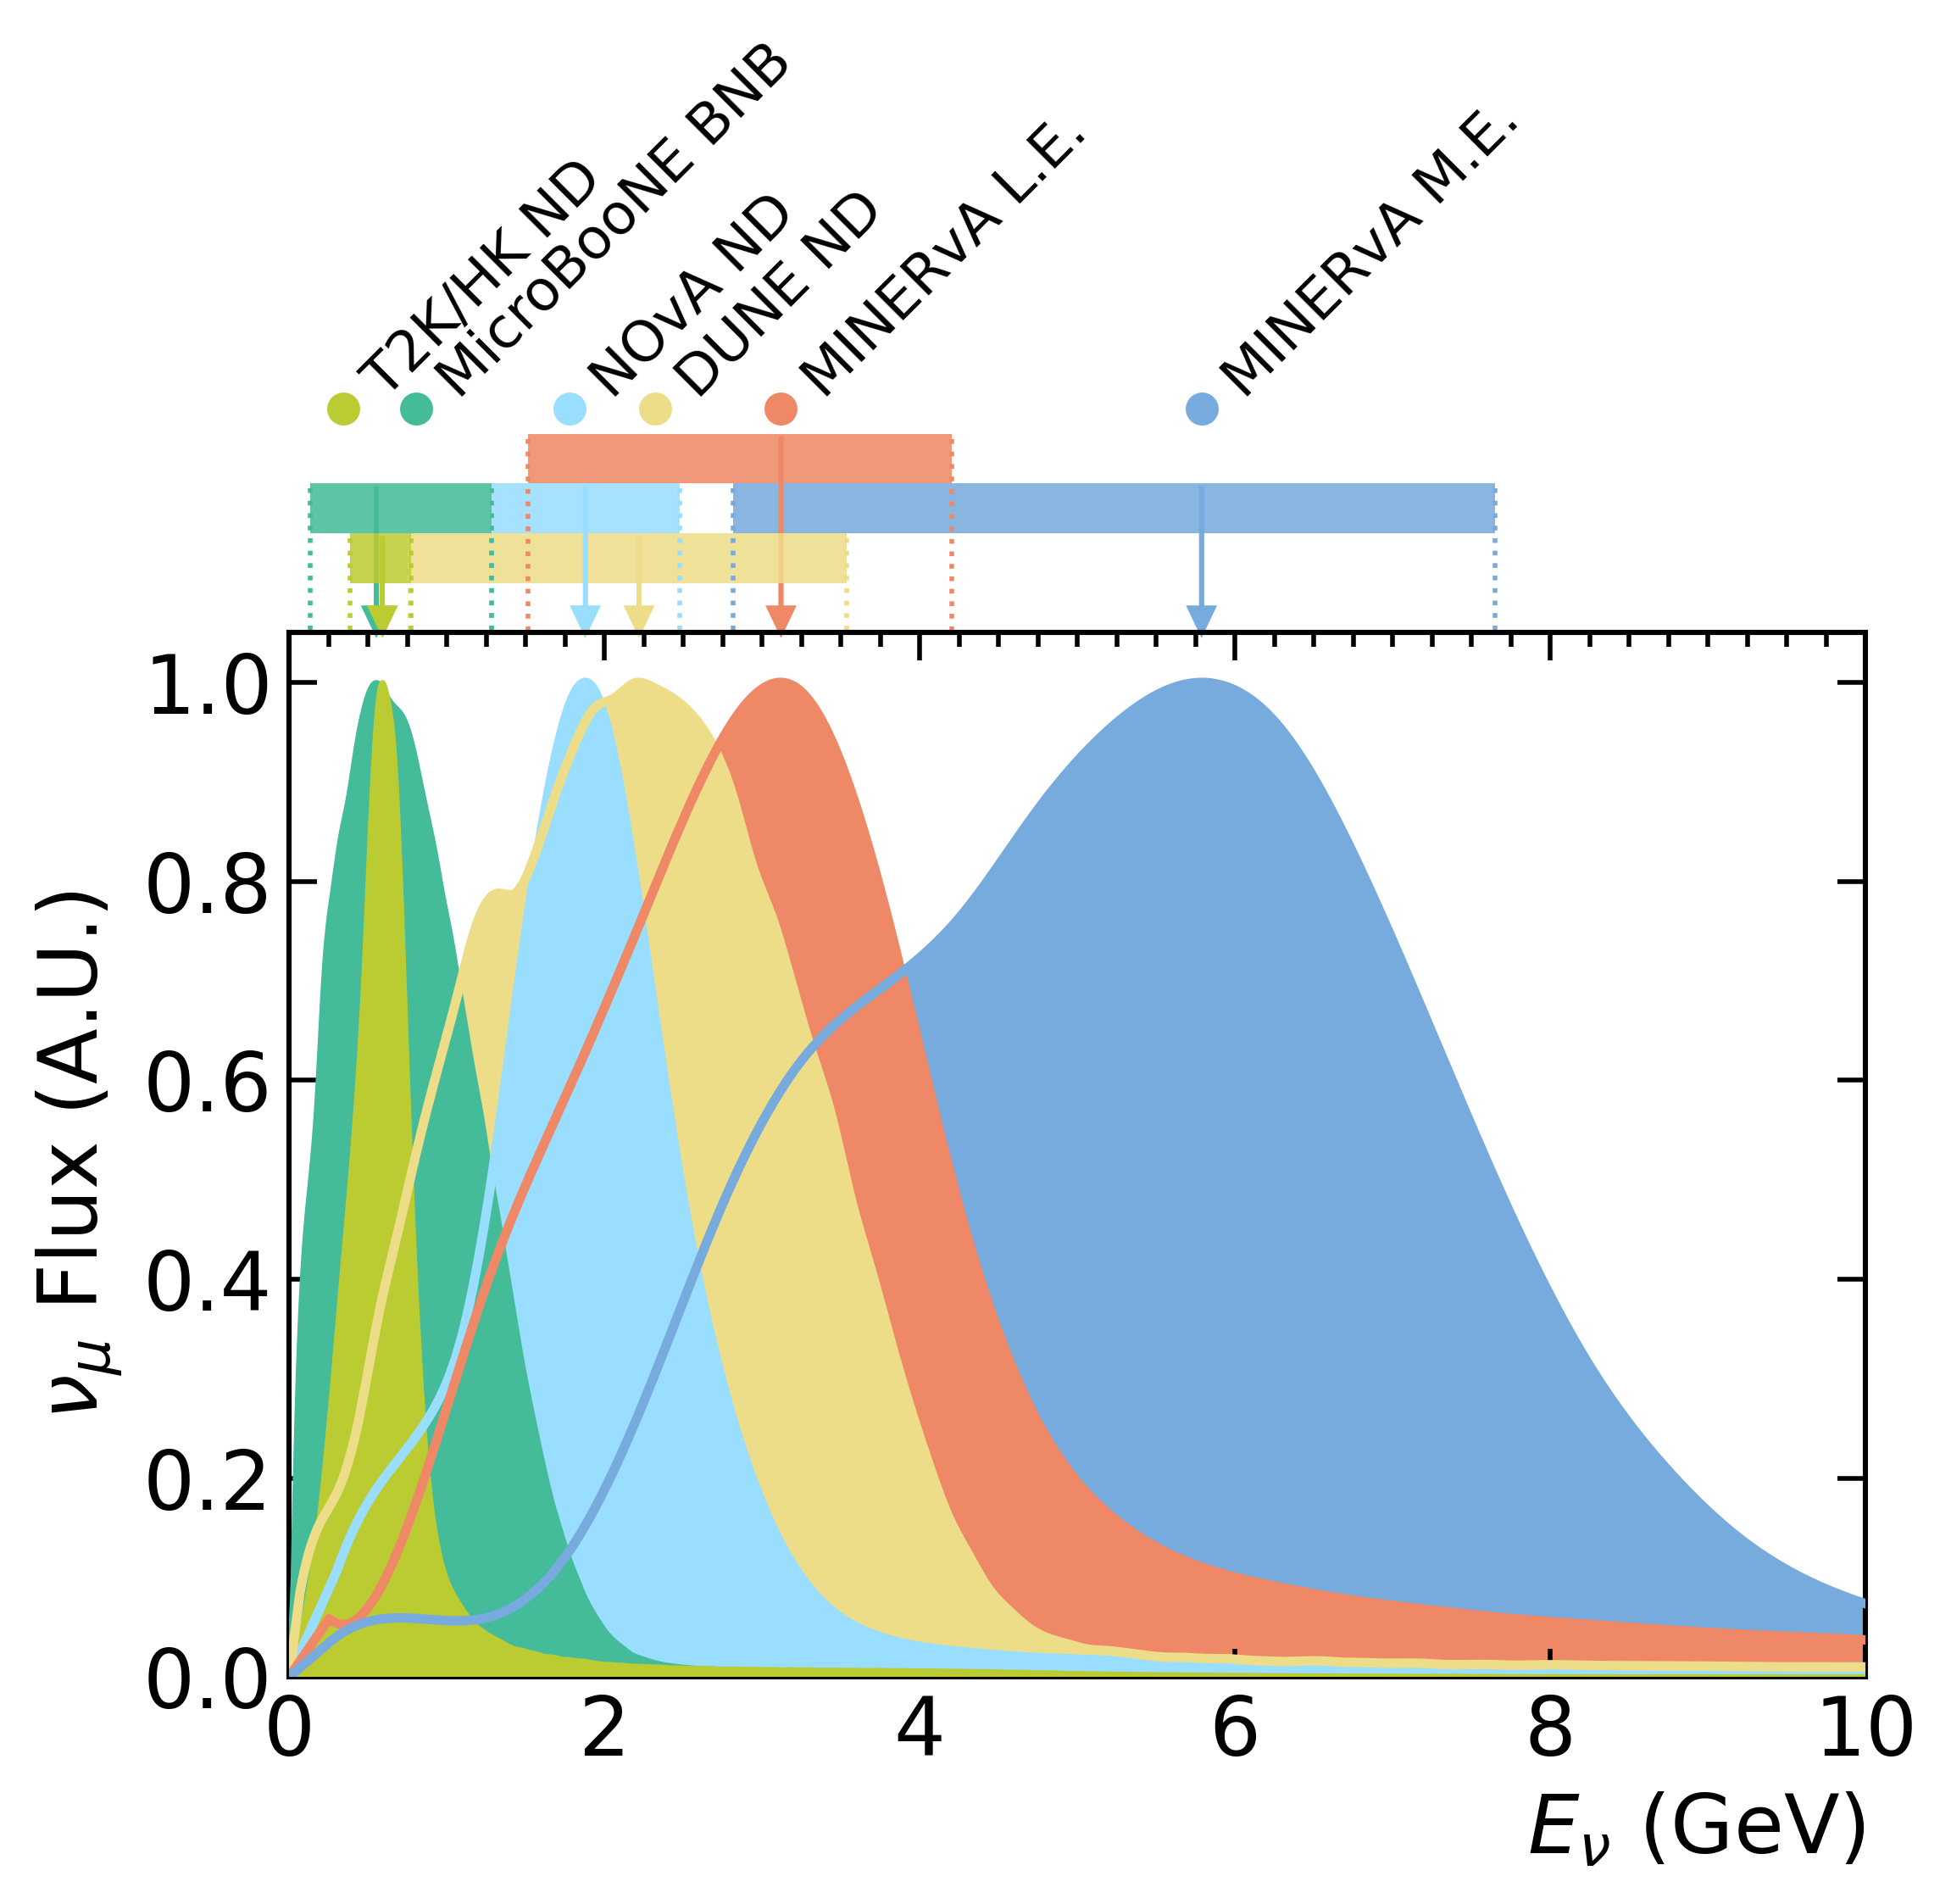

In [74]:
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

cols = [ '#77AADD', '#EE8866', '#EEDD88', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD' ]
label_x_shifts = [0,0,0.1,-0.1,0.25,-0.25]
draw_line = [1,1,1,1,0,0]
recth_line = [-0.25,-0.3,-0.2,-0.25,-0.25,-0.2]
recth_line = [1.15,1.2,1.1,1.15,1.15,1.1]

plt.xlim([0,10])
plt.ylim([0,1.05])

def getfwhm(interp, rng, scale):
    lower = None
    last = 0
    step = ((rng[1] - rng[0])/10000.0)
    for x in [rng[0] + (x * step) for x in range(10000)]:
        now = interp(x)/scale
        if (now >= 0.5) and (last < 0.5):
            lower = (x - step) + (0.5 - last)/(now - last) * step
        if (now <= 0.5) and (last > 0.5):
            upper = (x - step) + (last - 0.5)/(last - now) * step
            return (lower, upper)
        last = now

MFWHMs={}

for i, (fn,f) in enumerate(fluxes):
    bin_centers = f.get_bin_centers()
    interp = scipy.interpolate.CubicSpline(bin_centers,f.get_flux_shape_density())
    logpoints = pn.Binning.get_bin_centers1D(pn.Binning.lin_space(bin_centers[0], bin_centers[-1], 10000).bins)
    yp = [interp(x) for x in logpoints]
    ymax = np.max(yp)
    yp = [x/ymax for x in yp]
    logpoints.insert(0,0)
    yp.insert(0,0)
    
    plt.fill(logpoints, yp, label=fn, color=cols[i],zorder=i)
    if draw_line[i] == 1:
        plt.plot(logpoints, yp, linewidth=2, color=cols[i],zorder=(2*len(fluxes) - i))

    xmaxi = np.argmax(yp)
    plt.scatter([logpoints[xmaxi]+label_x_shifts[i]],[1.275],clip_on=False,color=cols[i])
    plt.text(logpoints[xmaxi]+label_x_shifts[i],1.275, " %s" % fn, rotation=45,fontsize="large")

    fwhm = getfwhm(interp, [logpoints[0],logpoints[-1]], ymax)
    MFWHMs[fn] = (fwhm, logpoints[xmaxi], cols[i])
    
    plt.gca().add_patch(Rectangle((fwhm[0], recth_line[i]), fwhm[1] - fwhm[0], 0.05,
                                  clip_on=False, facecolor="%sDD"%cols[i]))
    plt.arrow(logpoints[xmaxi], recth_line[i]+0.045, 0, 1.05 - (recth_line[i]+0.045), clip_on=False, linewidth=1, color=cols[i],
              length_includes_head=True,
              shape="full",
              head_width=0.15,head_length=0.025)
    plt.plot([fwhm[0], fwhm[0]], [recth_line[i]+0.045, 1.05], clip_on=False, linewidth=1, linestyle="dotted", color=cols[i])
    plt.plot([fwhm[1], fwhm[1]], [recth_line[i]+0.045, 1.05], clip_on=False, linewidth=1, linestyle="dotted", color=cols[i])

print(MFWHMs)

plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(bottom=True, top=True, which="both")

plt.xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large", loc="right")
plt.xticks(fontsize="xx-large")
plt.ylabel(r"$\nu_\mu$ Flux (A.U.)",fontsize="xx-large")
plt.yticks(fontsize="xx-large")

plt.savefig("flux_disco.png",dpi=400, bbox_inches='tight')
plt.savefig("flux_disco.svg", bbox_inches='tight')
plt.show()

{'LBNF $0^\\circ$': ((0.7669280897589236, 3.535955357421045), 2.2199968750000036, '#77AADD'), 'BNB': ((0.13528973863026617, 1.2859511757978275), 0.5538624999999928, '#EE8866'), 'JPARC $2.5^\\circ$': ((0.38724101111758524, 0.7761730422418079), 0.5923937499999989, '#EEDD88')}


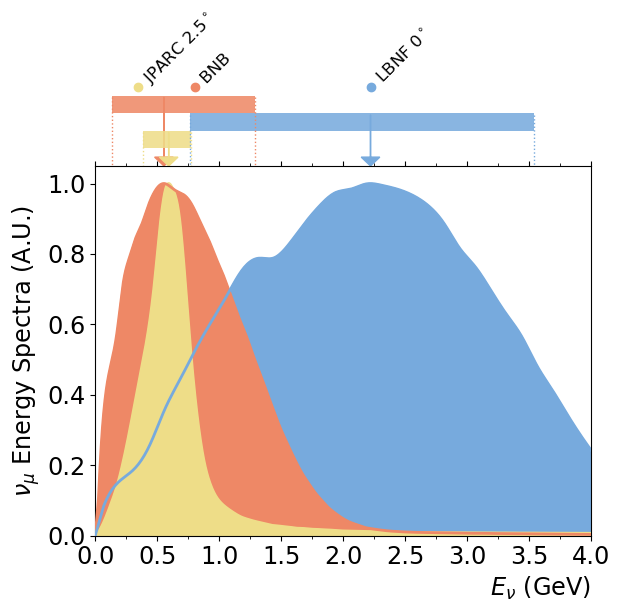

In [5]:
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

fluxes_less = [
           (r"LBNF $0^\circ$", DUNE_Flux),
           ("BNB", ub_Flux),
           (r"JPARC $2.5^\circ$",T2K_Flux),]

cols = [ '#77AADD', '#EE8866', '#EEDD88', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD' ]
label_x_shifts = [0,0.25,-0.25]
draw_line = [1,1,1,1,0,0]
recth_line = [-0.25,-0.3,-0.2,-0.25,-0.25,-0.2]
recth_line = [1.15,1.2,1.1,1.15,1.15,1.1]

plt.xlim([0,4])
plt.ylim([0,1.05])

def getfwhm(interp, rng, scale):
    lower = None
    last = 0
    step = ((rng[1] - rng[0])/10000.0)
    for x in [rng[0] + (x * step) for x in range(10000)]:
        now = interp(x)/scale
        if (now >= 0.5) and (last < 0.5):
            lower = (x - step) + (0.5 - last)/(now - last) * step
        if (now <= 0.5) and (last > 0.5):
            upper = (x - step) + (last - 0.5)/(last - now) * step
            return (lower, upper)
        last = now

MFWHMs={}

for i, (fn,f) in enumerate(fluxes_less):
    bin_centers = f.get_bin_centers()
    interp = scipy.interpolate.CubicSpline(bin_centers,f.get_flux_shape_density())
    logpoints = pn.Binning.get_bin_centers1D(pn.Binning.lin_space(bin_centers[0], bin_centers[-1], 10000).bins)
    yp = [interp(x) for x in logpoints]
    ymax = np.max(yp)
    yp = [x/ymax for x in yp]
    logpoints.insert(0,0)
    yp.insert(0,0)
    
    plt.fill(logpoints, yp, label=fn, color=cols[i],zorder=i)
    if draw_line[i] == 1:
        plt.plot(logpoints, yp, linewidth=2, color=cols[i],zorder=(2*len(fluxes) - i))

    xmaxi = np.argmax(yp)
    plt.scatter([logpoints[xmaxi]+label_x_shifts[i]],[1.275],clip_on=False,color=cols[i])
    plt.text(logpoints[xmaxi]+label_x_shifts[i],1.275, " %s" % fn, rotation=45,fontsize="large")

    fwhm = getfwhm(interp, [logpoints[0],logpoints[-1]], ymax)
    MFWHMs[fn] = (fwhm, logpoints[xmaxi], cols[i])
    
    plt.gca().add_patch(Rectangle((fwhm[0], recth_line[i]), fwhm[1] - fwhm[0], 0.05,
                                  clip_on=False, facecolor="%sDD"%cols[i]))
    plt.arrow(logpoints[xmaxi], recth_line[i]+0.045, 0, 1.05 - (recth_line[i]+0.045), clip_on=False, linewidth=1, color=cols[i],
              length_includes_head=True,
              shape="full",
              head_width=0.15,head_length=0.025)
    plt.plot([fwhm[0], fwhm[0]], [recth_line[i]+0.045, 1.05], clip_on=False, linewidth=1, linestyle="dotted", color=cols[i])
    plt.plot([fwhm[1], fwhm[1]], [recth_line[i]+0.045, 1.05], clip_on=False, linewidth=1, linestyle="dotted", color=cols[i])

print(MFWHMs)

plt.gca().xaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(bottom=True, top=True, which="both")

plt.xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large", loc="right")
plt.xticks(fontsize="xx-large")
plt.ylabel(r"$\nu_\mu$ Energy Spectra (A.U.)",fontsize="xx-large")
plt.yticks(fontsize="xx-large")

plt.savefig("flux_disco.png",dpi=400, bbox_inches='tight')
plt.show()

# xsecosc plot

In [7]:
files_low = ["/root/scratch/IOPPaper/gengen_low_%s/ghep.low.%s.root" % (x,x) for x in range(10) ]
files_high = ["/root/scratch/IOPPaper/gengen_high_%s/ghep.high.%s.root" % (x,x) for x in range(10) ]

evs_low = pn.EventSource({
    "event-generator-list":"Default",
    "filepaths":files_low,
    "spline_file": "/root/scratch/IOPPaper/IOP_review_scripts/generation/MC_inputs/G18_10a_00_000_v320_splines.xml.gz",
    "tune": "G18_10a_00_000"
    })
if not evs_low:
    print("Error: failed to open input file")

evs_high = pn.EventSource({
    "event-generator-list":"Default",
    "filepaths":files_high,
    "spline_file": "/root/scratch/IOPPaper/IOP_review_scripts/generation/MC_inputs/G18_10a_00_000_v320_splines.xml.gz",
    "tune": "G18_10a_00_000"
    })
if not evs_high:
    print("Error: failed to open input file")

1735572928 NOTICE RunOpt : [n] <RunOpt.cxx::SetTuneName (85)> : RunOpt::SetTune() already had G18_10a_00_000, now being re-set to G18_10a_00_000
1735572928 INFO TuneId : [n] <TuneId.cxx::Build (132)> : G18_10a_00_000 Tune configured 
1735572928 INFO RunOpt : [n] <RunOpt.cxx::BuildTune (94)> : Building tune G18_10a_00_000
1735572928 INFO TuneId : [n] <TuneId.cxx::Build (132)> : G18_10a_00_000 Tune configured 
1735572929 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_A = 0
1735572929 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A < 420 -> using MagFF_RT_A = 5.19
1735572929 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 0 < A < 12 -> using MagFF_RT_B = 1
1735572929 INFO TransverseEnhancementFFModel : [n] <ConfigIsotopeMapUtils.cxx::LoadAllNucARangesForKey (61)> : For 11 < A < 420 -> us

In [12]:
from pyProSelecta import event, part, unit, pdg, p3mod, momentum, ext

def sample_topo(ev):
    if not event.has_beam_part(ev, pdg.kNuMu):
        return 0 #bad

    if not event.has_out_part(ev, pdg.kMuon):
        return 1 #NC

    nparts = event.num_out_part(ev)

    nmuons = event.num_out_part(ev, pdg.kMuon)
    ncpi = event.num_out_part(ev, [pdg.kPiMinus, pdg.kPiPlus], flatten=True)
    npi0 = event.num_out_part(ev, pdg.kPiZero)
    ngammas = event.num_out_part(ev, pdg.kGamma)

    nexotic = event.num_out_part_except(ev, [pdg.kMuon, pdg.kProton, pdg.kNeutron, 
                                             pdg.kPiZero, pdg.kPiMinus, pdg.kPiPlus, 
                                             pdg.kGamma])

    if nexotic > 0:
        return 2 # Other

    if (ngammas > 0) and \
       (event.hm_out_part(ev, pdg.kGamma).momentum().e() > (25 * unit.MeV)):
        return 2 # Other

    if ((nmuons != 1) or (npi0 != 0) or (ncpi > 1)):
        return 2 # Other
  
    if ncpi == 1:
        return 3 # 1cpi

    return 4 #0pi

def sample_mode(ev):
    procid = event.signal_process_id(ev)

    if not event.has_beam_part(ev, pdg.kNuMu):
        return 0 #bad

    if not event.has_out_part(ev, pdg.kMuon):
        return 1 #NC

    if (200 <= procid) and (procid < 300): #qe
        return 2
    elif (300 <= procid) and (procid < 400): #2p2h
        return 3
    elif (400 <= procid) and (procid < 500): #res
        return 4
    elif (500 <= procid) and (procid < 700): #sis+dis
        return 5
    return 6

In [13]:
fg_low = pn.EventFrameGen(evs_low) \
    .add_column("enu_GeV", ext.enu_GeV) \
    .add_column("sample_mode", sample_mode) \
    .add_column("sample_topo", sample_topo)

fg_high = pn.EventFrameGen(evs_high) \
    .add_column("enu_GeV", ext.enu_GeV) \
    .add_column("sample_mode", sample_mode) \
    .add_column("sample_topo", sample_topo)

In [14]:
chunk_low = fg_low.all()
chunk_high = fg_high.all()

In [17]:
print(chunk_low.bottomRows(20))
print(chunk_high.bottomRows(20))

 -------------------------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id | enu_GeV | sample_mode | sample_topo |
 -------------------------------------------------------------------------------------------------------------
 |      2.5e+06 |         1 |    2.135e-07 |    5.337e-09 |        450 |   1.505 |           1 |           1 |
 |      2.5e+06 |         1 |    2.135e-07 |    5.337e-09 |        250 |  0.2889 |           1 |           1 |
 |      2.5e+06 |         1 |    2.135e-07 |    5.337e-09 |        200 |   1.365 |           2 |           4 |
 |      2.5e+06 |         1 |    2.135e-07 |    5.337e-09 |        400 |   1.785 |           4 |           4 |
 |      2.5e+06 |         1 |    2.135e-07 |    5.337e-09 |        400 |  0.9746 |           4 |           3 |
 |      2.5e+06 |         1 |    2.135e-07 |    5.337e-09 |        450 |   1.813 |           1 |           1 |
 

In [59]:
import copy
import numpy as np

def smooth(hist, binning):
    x_in = pn.Binning.get_bin_centers1D(hist.binning.bins)
    x_out = pn.Binning.get_bin_centers1D(binning.bins)

    sumw_out = np.empty(shape=(len(x_out),len(hist.column_info)))
    
    hist_out = pn.HistFrame(binning)
    for coli in hist.column_info:
        coln = coli.name
        ci = hist.find_column_index(coln)
        co = hist_out.find_column_index(coln)
        if co == pn.BinnedValuesBase.npos:
            co = hist_out.add_column(coln)
        y_in = hist.sumweights[:,ci]
        smooth_interp = scipy.interpolate.CubicSpline(x_in, y_in)

        for i,x in enumerate(x_out):
            sumw_out[i,ci] = smooth_interp(x)

    hist_out.sumweights = sumw_out
    return hist_out

def getxsec_GeV(enu_GeV_hist, flux, per_enu=False):
    flux.set_units("GEV")

    flux_bin_centers = flux.get_bin_centers()
    flux_shape_interp = scipy.interpolate.CubicSpline(flux.get_bin_centers(), flux.get_flux_shape_density())

    sumw = enu_GeV_hist.sumweights.copy()
    var = enu_GeV_hist.variances.copy()
    num_rows, num_cols = sumw.shape

    for ri,b in enumerate(enu_GeV_hist.binning.bins):
        enu_ext = b[0]
        
        #only cover bins in in the input flux
        if( (enu_ext.high < flux.bin_edges[0]) or (flux.bin_edges[-1] < enu_ext.low) ):
            continue

        frac_of_flux_averaged_nu = ((flux_shape_interp(enu_ext.low) + flux_shape_interp(enu_ext.high))/2.0) * (enu_ext.high - enu_ext.low)

        scale_factor = 1.0/frac_of_flux_averaged_nu
        if(per_enu):
            scale_factor /= ((enu_ext.low + enu_ext.high)/2.0)
        
        for ci in range(num_cols):
            sumw[ri,ci] *= scale_factor
            var[ri,ci] *= scale_factor*scale_factor

    xsec_hist = copy.copy(enu_GeV_hist)
    xsec_hist.sumweights = sumw
    xsec_hist.variances = var

    return xsec_hist

def make_xsec_hist(chunk_low, chunk_high, ni_low, ni_high):
    enu_hist_low = pn.HistFrame(pn.Binning.log10_space(0.1,10,25))

    xs_group_names = ["Bad", "NC","QE","2p2h","RES","SIS+DIS","Other"]
    
    enu_hist_high = copy.copy(enu_hist_low)
    
    enu_hist_low.fill(chunk_low, "enu_GeV", [pn.HistFrame.fill_column(0), 
                                             pn.HistFrame.categorize_by("sample_mode", xs_group_names)])
    enu_hist_high.fill(chunk_high, "enu_GeV", [pn.HistFrame.fill_column(0),
                                               pn.HistFrame.categorize_by("sample_mode", xs_group_names)])

    lowsf = ni_low.fatx_per_sumweights()
    highsf = ni_high.fatx_per_sumweights()

    xsec_low = getxsec_GeV(enu_hist_low, numu_flux_dist_low, True)
    xsec_high = getxsec_GeV(enu_hist_high, numu_flux_dist_high, True)
    
    xsec_low.sumweights *= lowsf
    xsec_high.sumweights *= highsf
    xsec_low.variances *= lowsf*lowsf
    xsec_high.variances *= highsf*highsf
    
    xsec = copy.copy(xsec_low)
    xsec.sumweights += xsec_high.sumweights
    xsec.variances += xsec_high.variances
    
    return xsec

In [77]:
numu_flux_dist_low = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/scratch/IOPPaper/flux_flat.root",
    "flow", "GEV", True)

numu_flux_dist_high = pn.convert.ROOT.get_EnergyDistribution_from_ROOT(\
    "/root/scratch/IOPPaper/flux_flat.root",
    "fhigh", "GEV", True)

In [78]:
xsec = make_xsec_hist(chunk_low, chunk_high, evs_low.norm_info(), evs_high.norm_info())

In [79]:
xsec_smooth = smooth(xsec, pn.Binning.lin_space(0.15,10,10000))
print([x.name for x in xsec_smooth.column_info])

['mc', 'Bad', 'NC', 'QE', '2p2h', 'RES', 'SIS+DIS', 'Other']


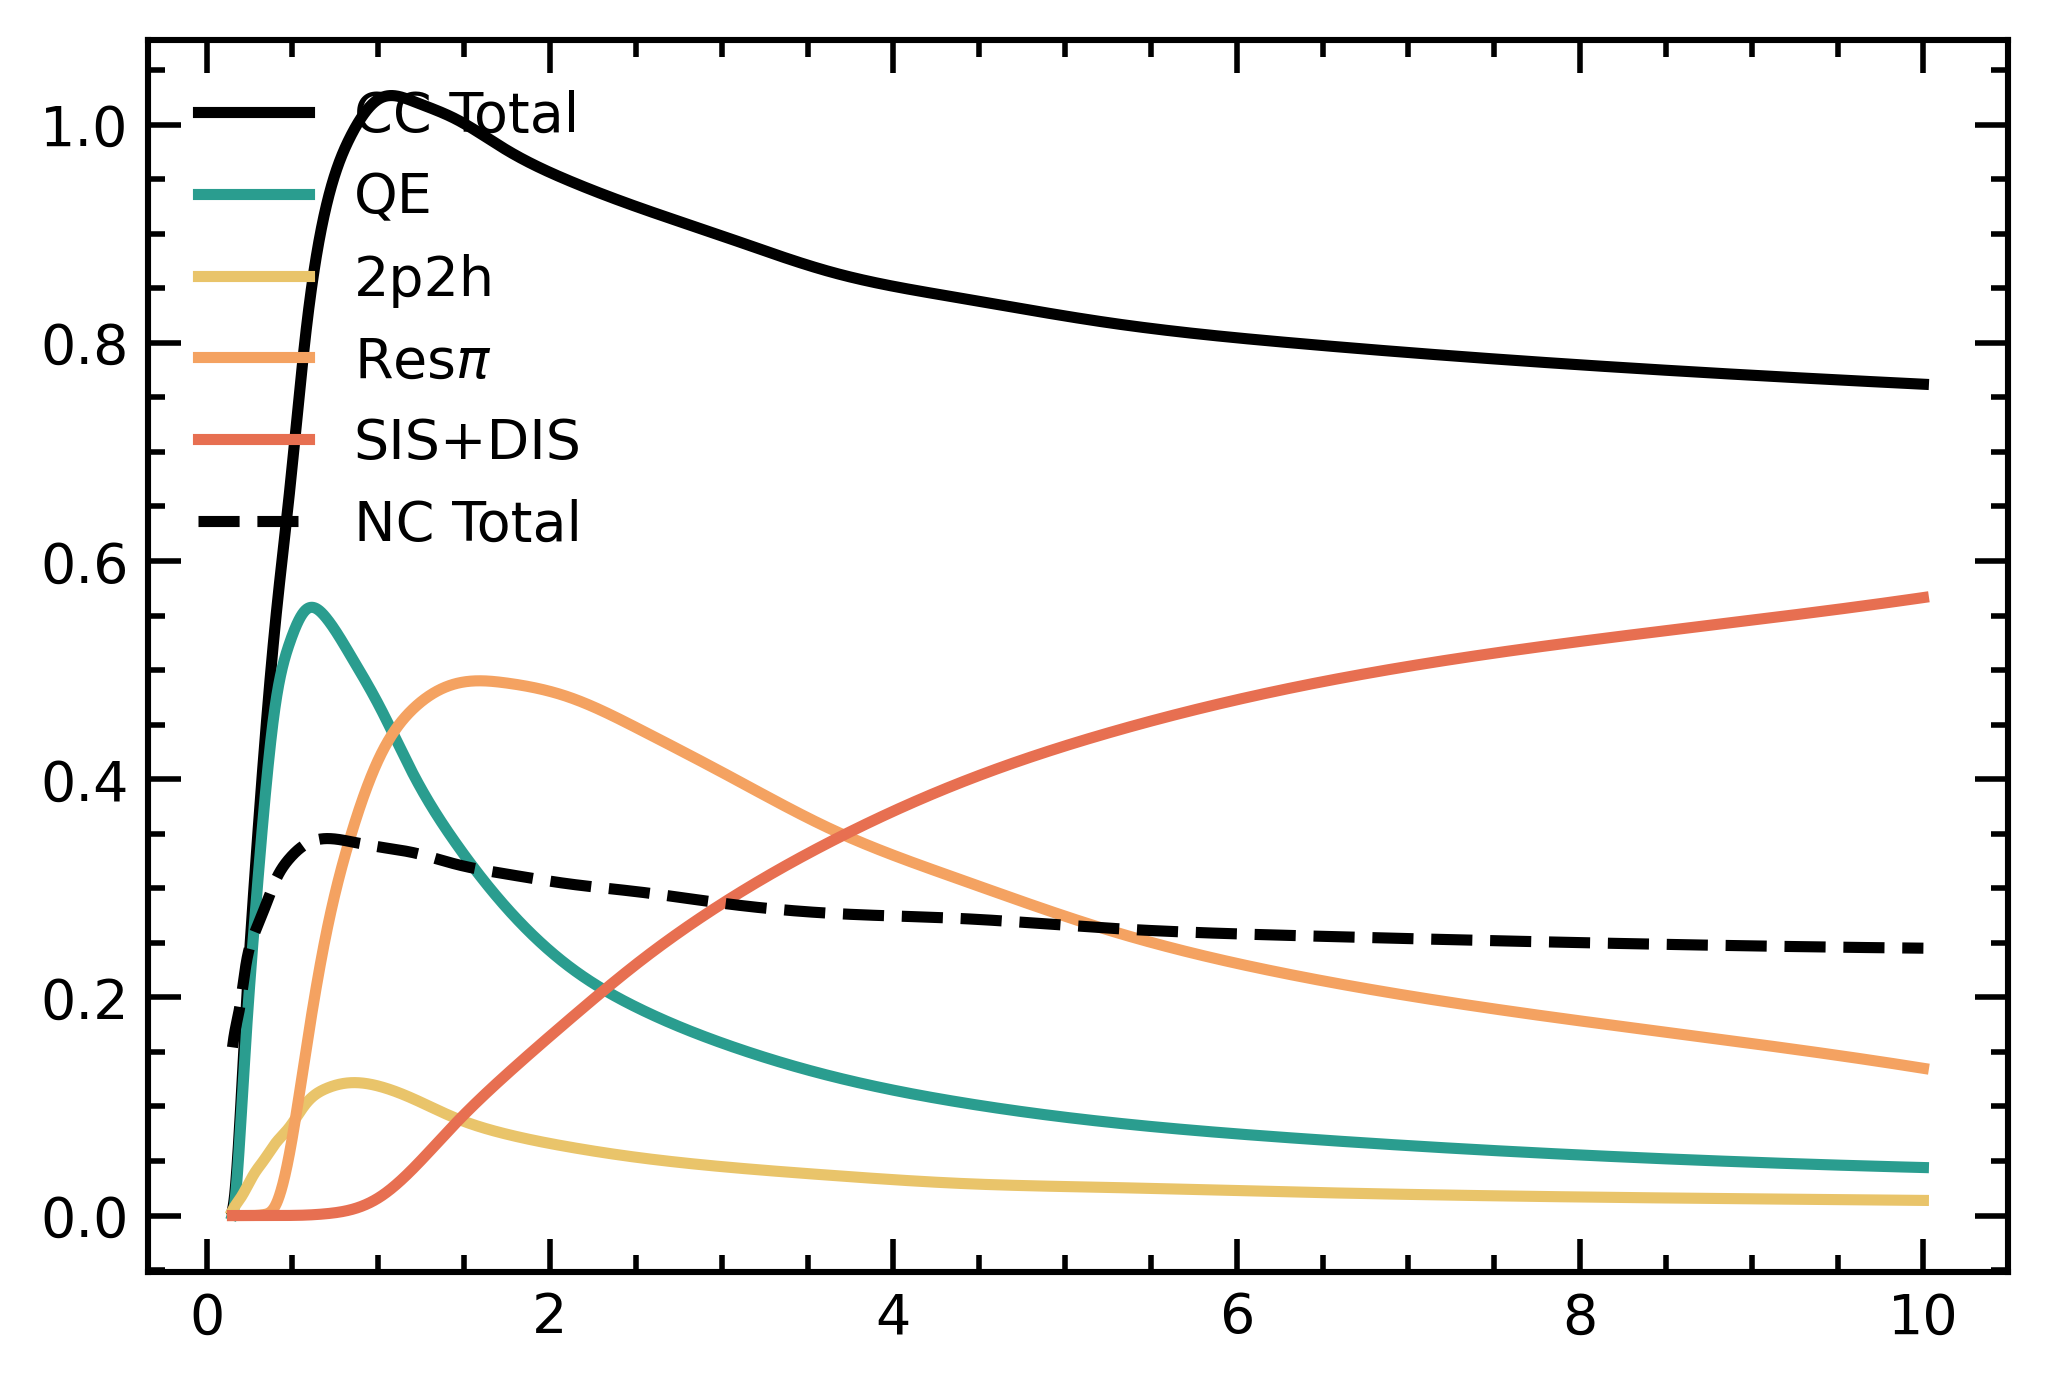

In [80]:
pn.cern([6,4])

xsec_smooth.mpl().plot_sum(columns=["QE","2p2h","RES","SIS+DIS", "Other"], linewidth=2, color="#000",label="CC Total")
xsec_smooth.mpl().plot(column="QE", linewidth=2,color="#2a9d8f",label="QE")
xsec_smooth.mpl().plot(column="2p2h", linewidth=2,color="#e9c46a",label="2p2h")
xsec_smooth.mpl().plot(column="RES", linewidth=2,color="#f4a261",label="Res$\pi$")
xsec_smooth.mpl().plot(column="SIS+DIS", linewidth=2,color="#e76f51",label="SIS+DIS")
xsec_smooth.mpl().plot(column="NC", linewidth=2,color="#000",label="NC Total", linestyle="dashed")

plt.legend()
plt.show()

In [81]:
def logpoints_density(flux_dist):
    bin_centers = flux_dist.get_bin_centers()
    interp = scipy.interpolate.CubicSpline(bin_centers,flux_dist.get_flux_density())
    logpoints = pn.Binning.get_bin_centers1D(pn.Binning.log10_space(bin_centers[0], bin_centers[-1], 1000).bins)
    yp = [interp(x) for x in logpoints]
    ymax = np.max(yp)
    yp = [x/ymax for x in yp]

    return (logpoints, yp)

def pin_to_zz(x,y):
    if x: x.insert(0,x[0])
    y.insert(0,0)
    return (x,y)

def pin_to_O(x,y):
    x.insert(0,0)
    y.insert(0,0)
    return (x,y)

In [82]:
dune_logd = logpoints_density(DUNE_Flux)

wnf5_disp_dune = pn.Prob3plusplusWeightCalc()
wnf5_disp_dune.set_parameters({"baseline_km": 1300, "NuFit:5.2": 1, "osc:numu_disp":1})
wnf5_app_dune = pn.Prob3plusplusWeightCalc()
wnf5_app_dune.set_parameters({"baseline_km": 1300, "NuFit:5.2": 1, "osc:numu_to_nue":1})

dosc_dune = [wnf5_disp_dune.prob(x)*y for x,y in zip(dune_logd[0],dune_logd[1])]
aosc_dune = [wnf5_app_dune.prob(x)*y for x,y in zip(dune_logd[0],dune_logd[1])]

dune_logdx, dune_logdy = pin_to_O(dune_logd[0], dune_logd[1])
_, aosc_dunen = pin_to_zz(None, aosc_dune)
_, dosc_dunen = pin_to_zz(None, dosc_dune)

nova_logd = logpoints_density(NOvA_Flux)

wnf5_disp_nova = pn.Prob3plusplusWeightCalc()
wnf5_disp_nova.set_parameters({"baseline_km": 810, "NuFit:5.2": 1, "osc:numu_disp":1})
wnf5_app_nova = pn.Prob3plusplusWeightCalc()
wnf5_app_nova.set_parameters({"baseline_km": 810, "NuFit:5.2": 1, "osc:numu_to_nue":1})

dosc_nova = [wnf5_disp_nova.prob(x)*y for x,y in zip(nova_logd[0],nova_logd[1])]
aosc_nova = [wnf5_app_nova.prob(x)*y for x,y in zip(nova_logd[0],nova_logd[1])]

nova_logdx, nova_logdy = pin_to_O(nova_logd[0], nova_logd[1])
_, aosc_novan = pin_to_zz(None, aosc_nova)
_, dosc_novan = pin_to_zz(None, dosc_nova)

t2k_logd = logpoints_density(T2K_Flux)

wnf5_disp_t2k = pn.Prob3plusplusWeightCalc()
wnf5_disp_t2k.set_parameters({"baseline_km": 295, "NuFit:5.2": 1, "osc:numu_disp":1})
wnf5_app_t2k = pn.Prob3plusplusWeightCalc()
wnf5_app_t2k.set_parameters({"baseline_km": 295, "NuFit:5.2": 1, "osc:numu_to_nue":1})

dosc_t2k = [wnf5_disp_t2k.prob(x)*y for x,y in zip(t2k_logd[0],t2k_logd[1])]
aosc_t2k = [wnf5_app_t2k.prob(x)*y for x,y in zip(t2k_logd[0],t2k_logd[1])]

t2k_logdx, t2k_logdy = pin_to_O(t2k_logd[0], t2k_logd[1])
_, aosc_t2kn = pin_to_zz(None, aosc_t2k)
_, dosc_t2kn = pin_to_zz(None, dosc_t2k)


Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!


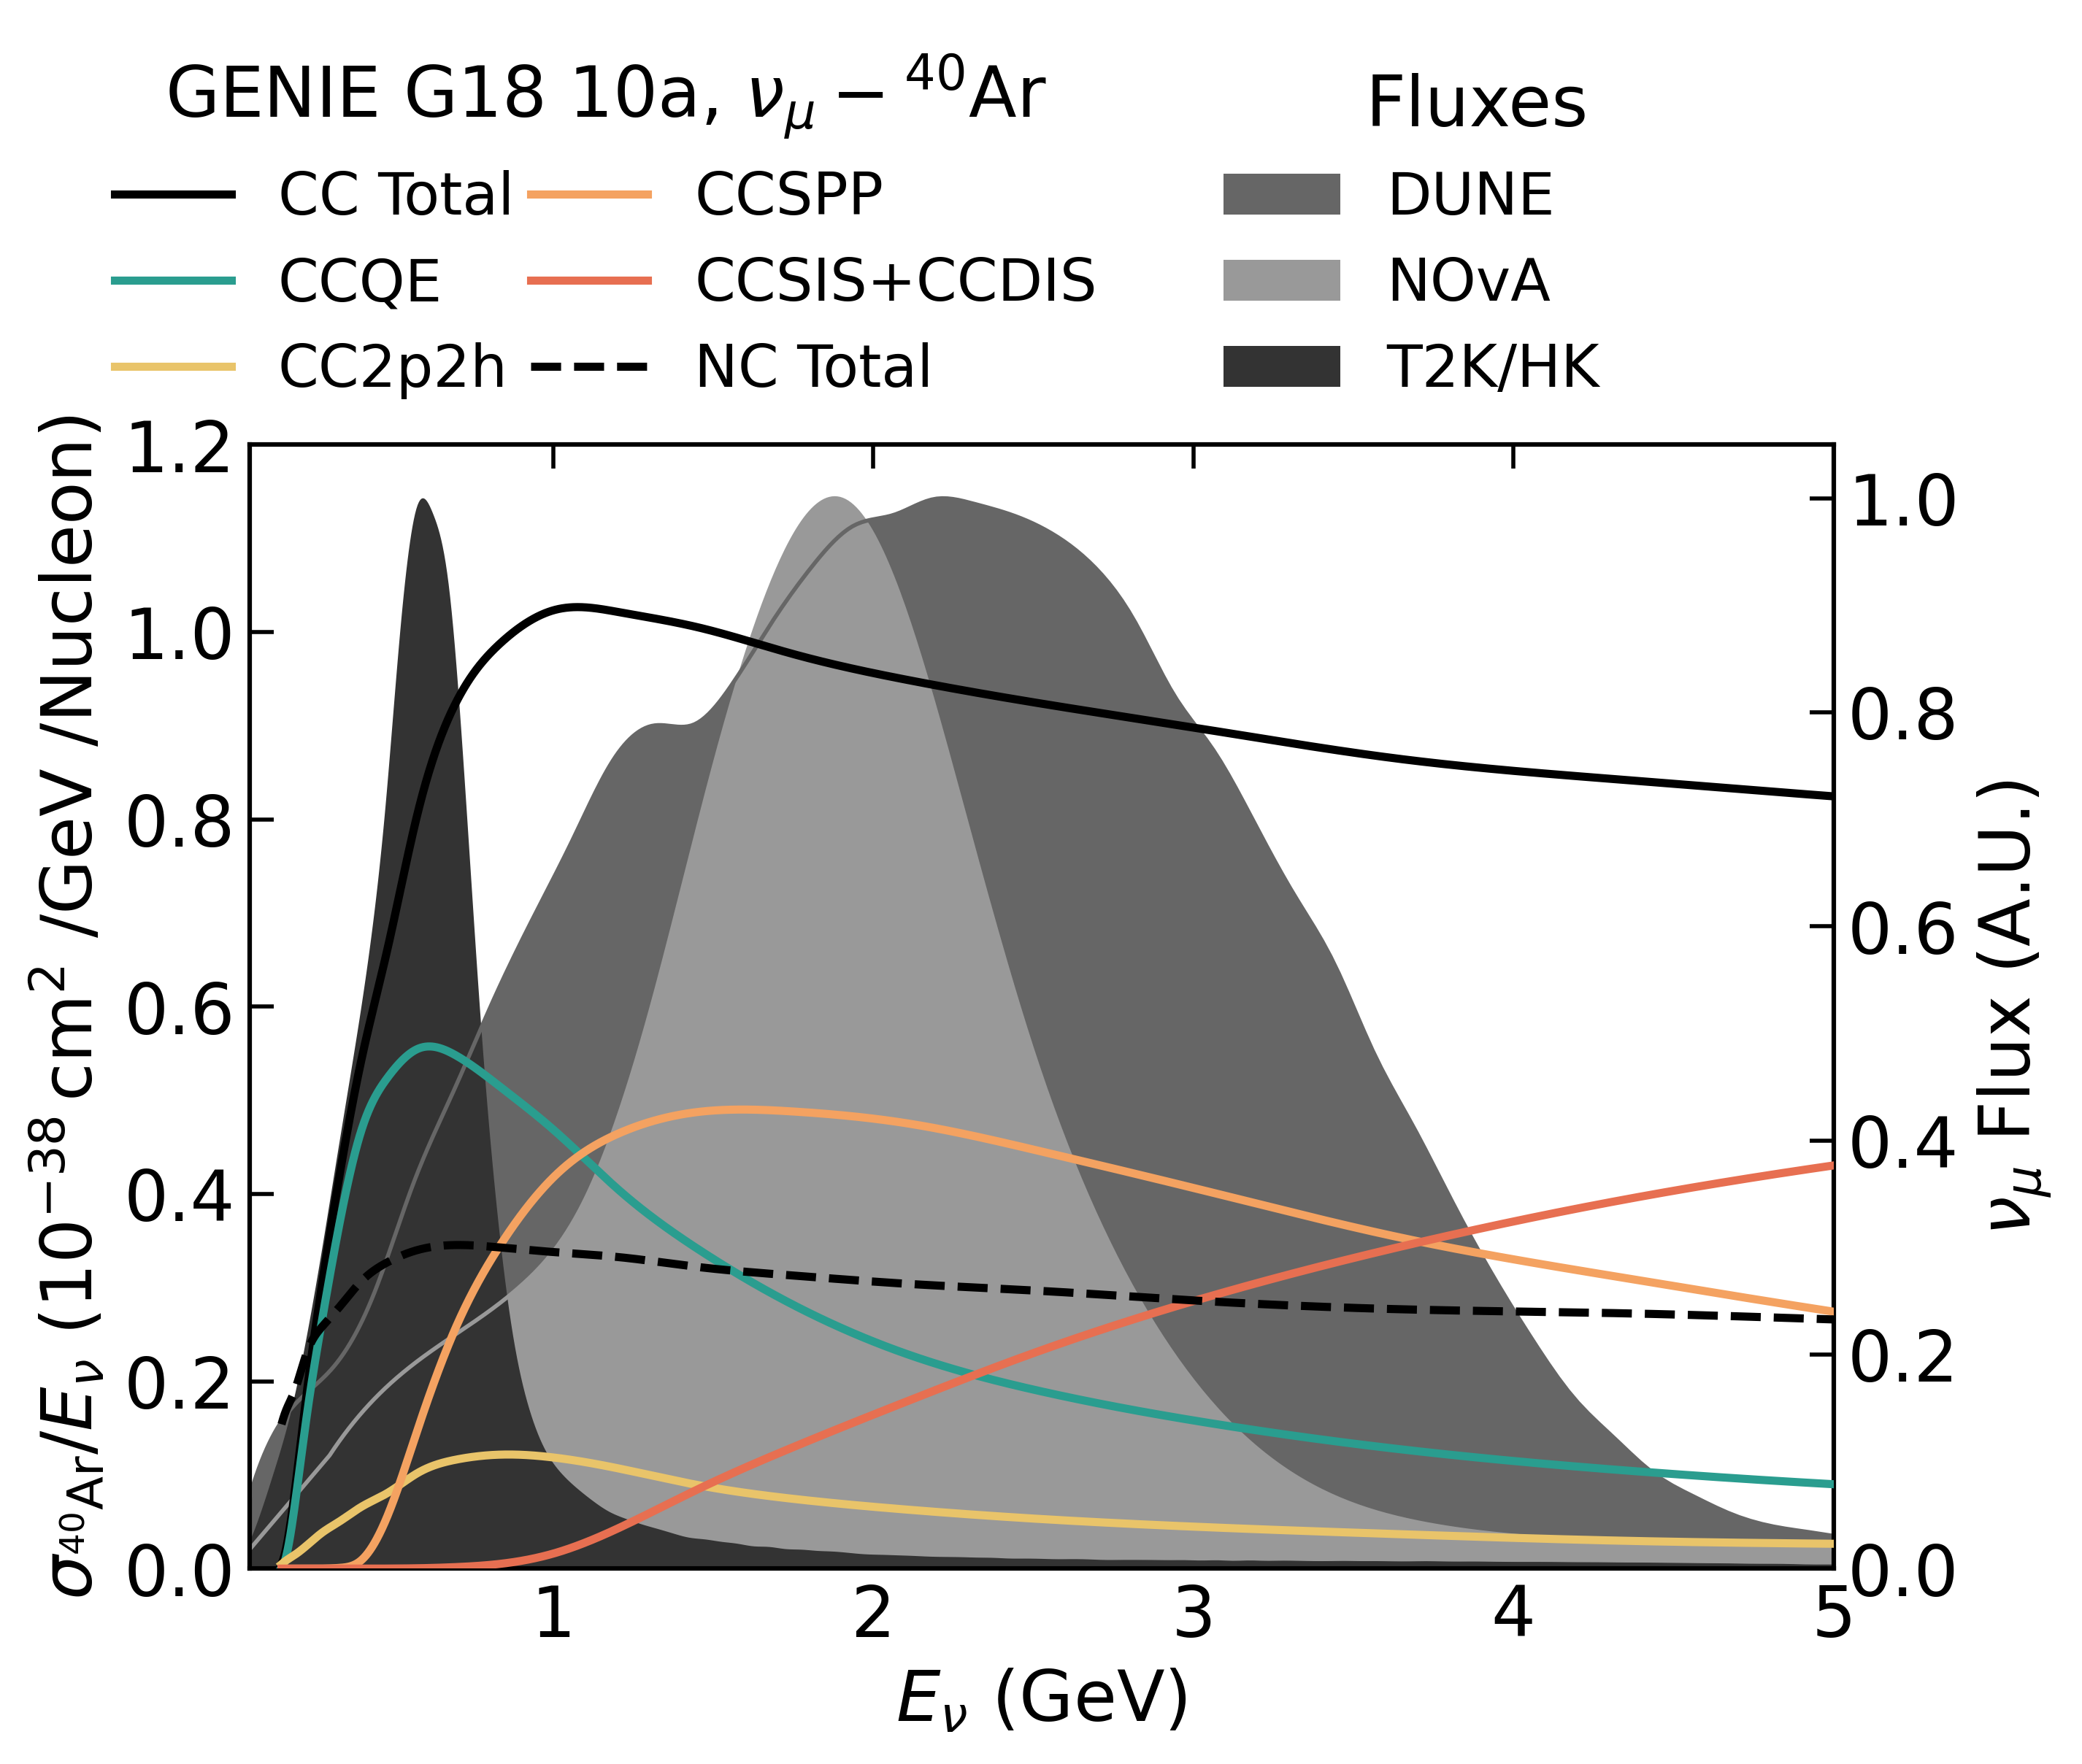

In [83]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(111)

ax1.set_xlim([0.05,5])
ax1.set_ylim([0,1.05])

ax1.fill(dune_logdx,dune_logdy, facecolor="#666",label="DUNE",zorder=1)
ax1.plot(dune_logdx,dune_logdy, color="#666", linewidth=1, linestyle="solid",zorder=8)
# ax1.fill(dune_logdx,dosc_dunen,color="#CCC",zorder=2)
# ax1.plot(dune_logdx,dosc_dunen,color="#FFF",linewidth=0.5,linestyle="dotted",zorder=5)

ax1.fill(nova_logdx,nova_logdy, facecolor="#999",label="NOvA",zorder=2)
ax1.plot(nova_logdx,nova_logdy, color="#999", linewidth=1, linestyle="solid",zorder=7)
# ax1.fill(nova_logdx,dosc_novan,color="#CCC",zorder=4)
# ax1.plot(nova_logdx,dosc_novan,color="#FFF",linewidth=0.5,linestyle="dashed",zorder=5)

ax1.fill(t2k_logdx,t2k_logdy, facecolor="#333",label="T2K/HK",zorder=6)
# ax1.fill(t2k_logdx,dosc_t2kn,color="#CCC",zorder=7)
# ax1.plot(t2k_logdx,dosc_t2kn,color="#FFF",linewidth=0.5,linestyle="solid",zorder=7)

ax1.legend(bbox_to_anchor=(0.6, 1.02, 0.35, .102), loc='lower left',
                      ncol=1, mode="expand", borderaxespad=0.,
          title="Fluxes", fontsize="x-large", title_fontsize="xx-large")

ax1.set_ylabel(r"$\nu_\mu$ Flux (A.U.)",fontsize="xx-large")
ax1.set_xlabel(r"$E_{\nu}$ (GeV)",fontsize="xx-large",loc="center")
ax1.tick_params(axis='x', labelsize="xx-large")

ax2 = ax1.twinx()

xsec_smooth.mpl().plot_sum(columns=["QE","2p2h","RES","SIS+DIS","Other"], plot_axis=ax2, linewidth=2, color="#000",label="CC Total", zorder=10)
xsec_smooth.mpl().plot(column="QE", plot_axis=ax2, linewidth=2,color="#2a9d8f",label="CCQE", zorder=10)
xsec_smooth.mpl().plot(column="2p2h", plot_axis=ax2, linewidth=2,color="#e9c46a",label="CC2p2h", zorder=10)
xsec_smooth.mpl().plot(column="RES", plot_axis=ax2, linewidth=2,color="#f4a261",label="CCSPP", zorder=10)
xsec_smooth.mpl().plot(column="SIS+DIS", plot_axis=ax2, linewidth=2,color="#e76f51",label="CCSIS+CCDIS", zorder=10)
xsec_smooth.mpl().plot(column="NC", plot_axis=ax2, linewidth=2,color="#000",label="NC Total", linestyle="dashed", zorder=10)

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis='y', labelsize="xx-large")

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim([0,1.2])
ax2.tick_params(axis='y', labelsize="xx-large")

ax2.set_ylabel(r"$\sigma_{{}^{40}\mathrm{Ar}}/E_{\nu}\ (10^{-38}\,\mathrm{cm}^{2}\ /\mathrm{GeV}\ /\mathrm{Nucleon})$",fontsize="xx-large",loc="center")

ax2.legend(bbox_to_anchor=(-0.1, 1.02, 0.65, .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0.,
          title=r"GENIE G18 10a, $\nu_{\mu}-{}^{40}\mathrm{Ar}$",
          fontsize="x-large", title_fontsize="xx-large")

mydpi=400
# plt.figure(figsize=(800/mydpi, 800/mydpi), dpi=mydpi)
plt.savefig("oscexpt_xsecoverlay.png", bbox_inches='tight', dpi=mydpi)
plt.savefig("oscexpt_xsecoverlay.svg", bbox_inches='tight')
plt.show()

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


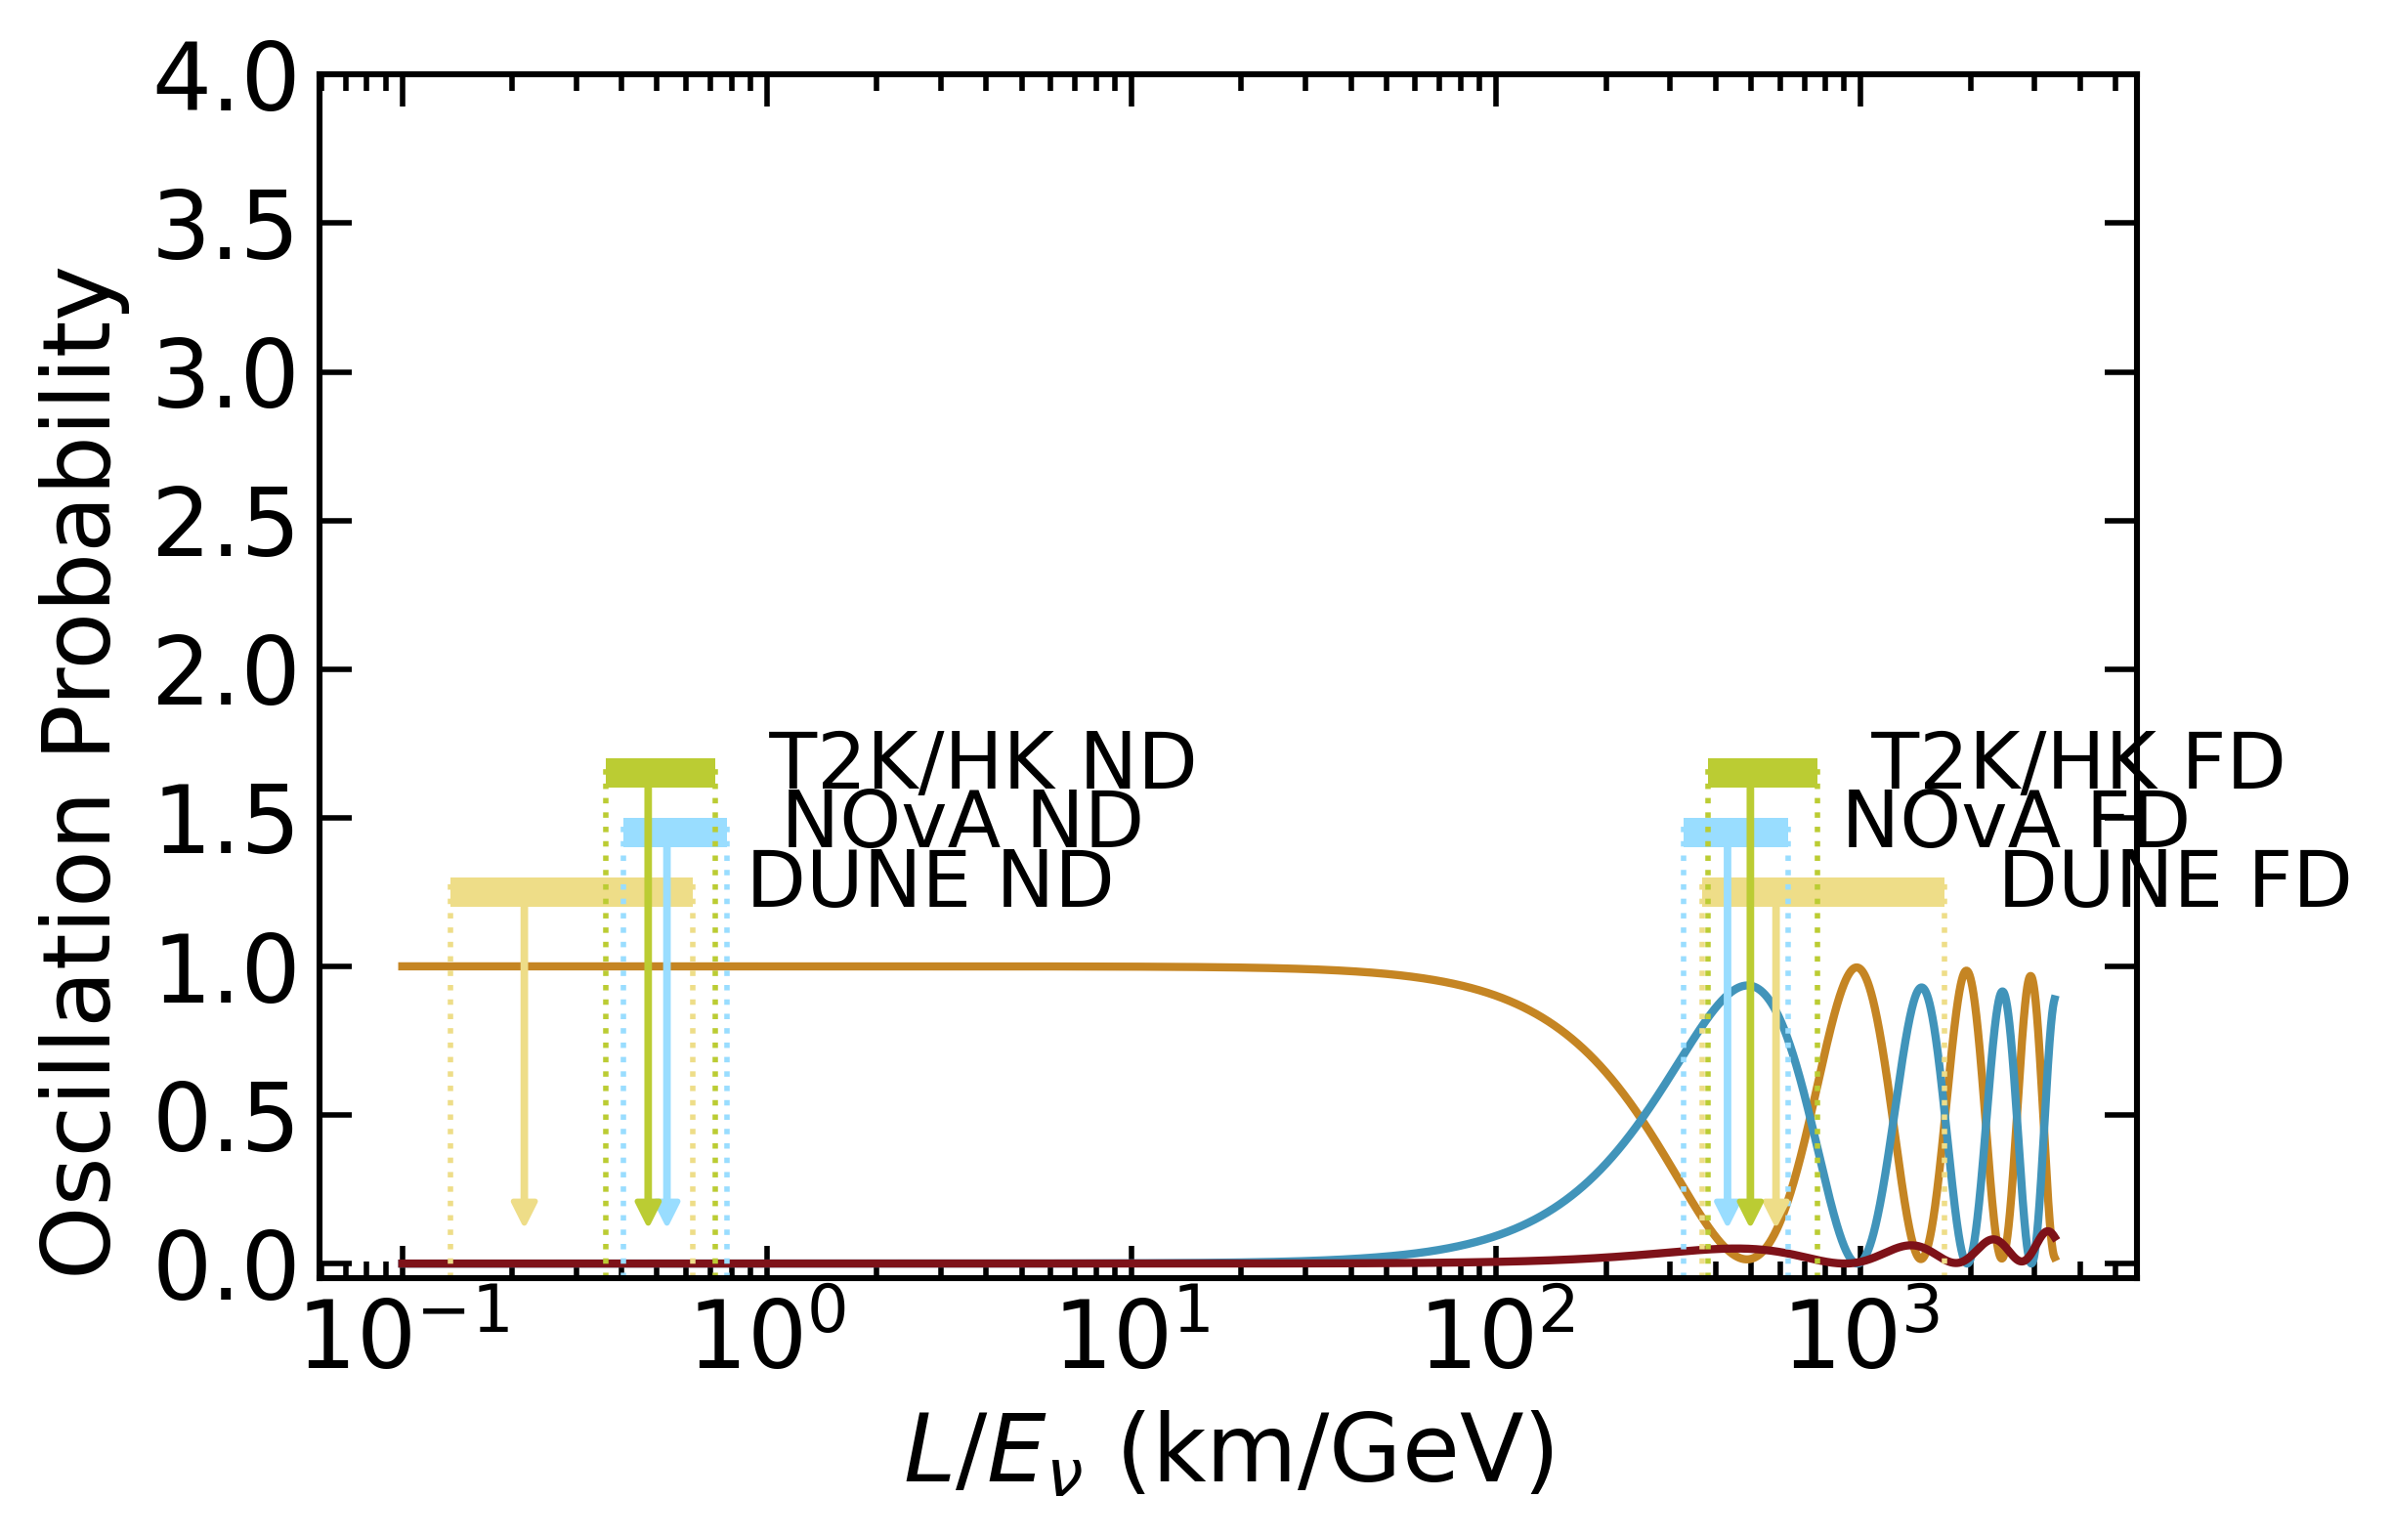

Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!


In [103]:
# print(MFWHMs)

import copy

MFWHMs["DUNE FD"] = MFWHMs["DUNE ND"]
MFWHMs["NOvA FD"] = MFWHMs["NOvA ND"]
MFWHMs["T2K/HK FD"] = MFWHMs["T2K/HK ND"]

Ls = {
    "DUNE FD": 1300.0,
    "NOvA FD": 810.0,
    "T2K/HK FD": 295.0,
    "DUNE ND": 0.480,
    "NOvA ND": 1,
    "T2K/HK ND": 0.280,
}

shifts = {
    "DUNE FD": 400,
    "NOvA FD": -175,
    "T2K/HK FD": 0,
    "DUNE ND": 0,
    "NOvA ND": 0,
    "T2K/HK ND": 0,
}

heights = {
    "DUNE FD": 1.2,
    "NOvA FD": 1.4,
    "T2K/HK FD": 1.6,
    "DUNE ND": 1.2,
    "NOvA ND": 1.4,
    "T2K/HK ND": 1.6,
}

wnf5_disp2 = pn.Prob3plusplusWeightCalc()
wnf5_disp2.set_parameters({"baseline_km": 1, "NuFit:5.2": 1, "osc:numu_disp":1})

wnf5_app2 = pn.Prob3plusplusWeightCalc()
wnf5_app2.set_parameters({"baseline_km": 1, "NuFit:5.2": 1, "osc:numu_to_nue":1})

wnf5_tau2 = pn.Prob3plusplusWeightCalc()
wnf5_tau2.set_parameters({"baseline_km": 1, "NuFit:5.2": 1, "osc:from":14,"osc:to":16})


loe_points = pn.Binning.get_bin_centers1D(pn.Binning.log10_space(0.1, 3400, 10000).bins)

p_disp = [ wnf5_disp2.prob(1.0/x) for x in loe_points ]
p_app = [ wnf5_app2.prob(1.0/x) for x in loe_points ]
p_tau = [ wnf5_tau2.prob(1.0/x) for x in loe_points ]

prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']
print(def_colors)

plt.xscale("log")
plt.ylim([-0.05,4])
plt.xlabel(r"$L/E_{\nu}$ (km/GeV)",fontsize="xx-large")
plt.ylabel(r"Oscillation Probability",fontsize="xx-large", loc="bottom")
plt.plot(loe_points,p_disp, label=r"$\nu_{\mu}\rightarrow\nu_{\mu}$, Survival",color="#c58523")
plt.plot(loe_points,p_tau, label=r"$\nu_{\mu}\rightarrow\nu_\text{e}$, Appearance",color="#4194ba")
plt.plot(loe_points,p_app, label=r"$\nu_{\mu}\rightarrow\nu_\text{e}$, Appearance",color="#7e1219")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")

for i,(fn,l) in enumerate(Ls.items()):
    low = l/MFWHMs[fn][0][1]
    peak = l/MFWHMs[fn][1]
    high = l/MFWHMs[fn][0][0]
    col = MFWHMs[fn][2]
    # print("%s: [ %s, %s, %s ]" % (fn, low,peak,high))
    plt.gca().add_patch(Rectangle((low, heights[fn]), high - low, 0.1,
                                  clip_on=False, facecolor="%s"%col))

    plt.annotate('',xy=(peak,0.1), xycoords='data', 
                      xytext=(peak, heights[fn]+0.095), textcoords = 'data',
                   arrowprops={
                       "color":col,
                       "arrowstyle": 'simple,head_width=2,head_length=2',
                       "connectionstyle": 'arc3,rad=0'},
                   size=2)
    plt.plot([low,low], [-0.05,heights[fn]+0.095], 
             clip_on=False, linewidth=1, linestyle="dotted", color=col)
    plt.plot([high,high], [-0.05,heights[fn]+0.095], 
             clip_on=False, linewidth=1, linestyle="dotted", color=col)
    
    # plt.scatter(peak + shifts[fn],[1.5],clip_on=False,color=col)
    plt.text(high*1.2, heights[fn], " %s" % fn, fontsize="x-large")

plt.savefig("loe.svg",dpi=300)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


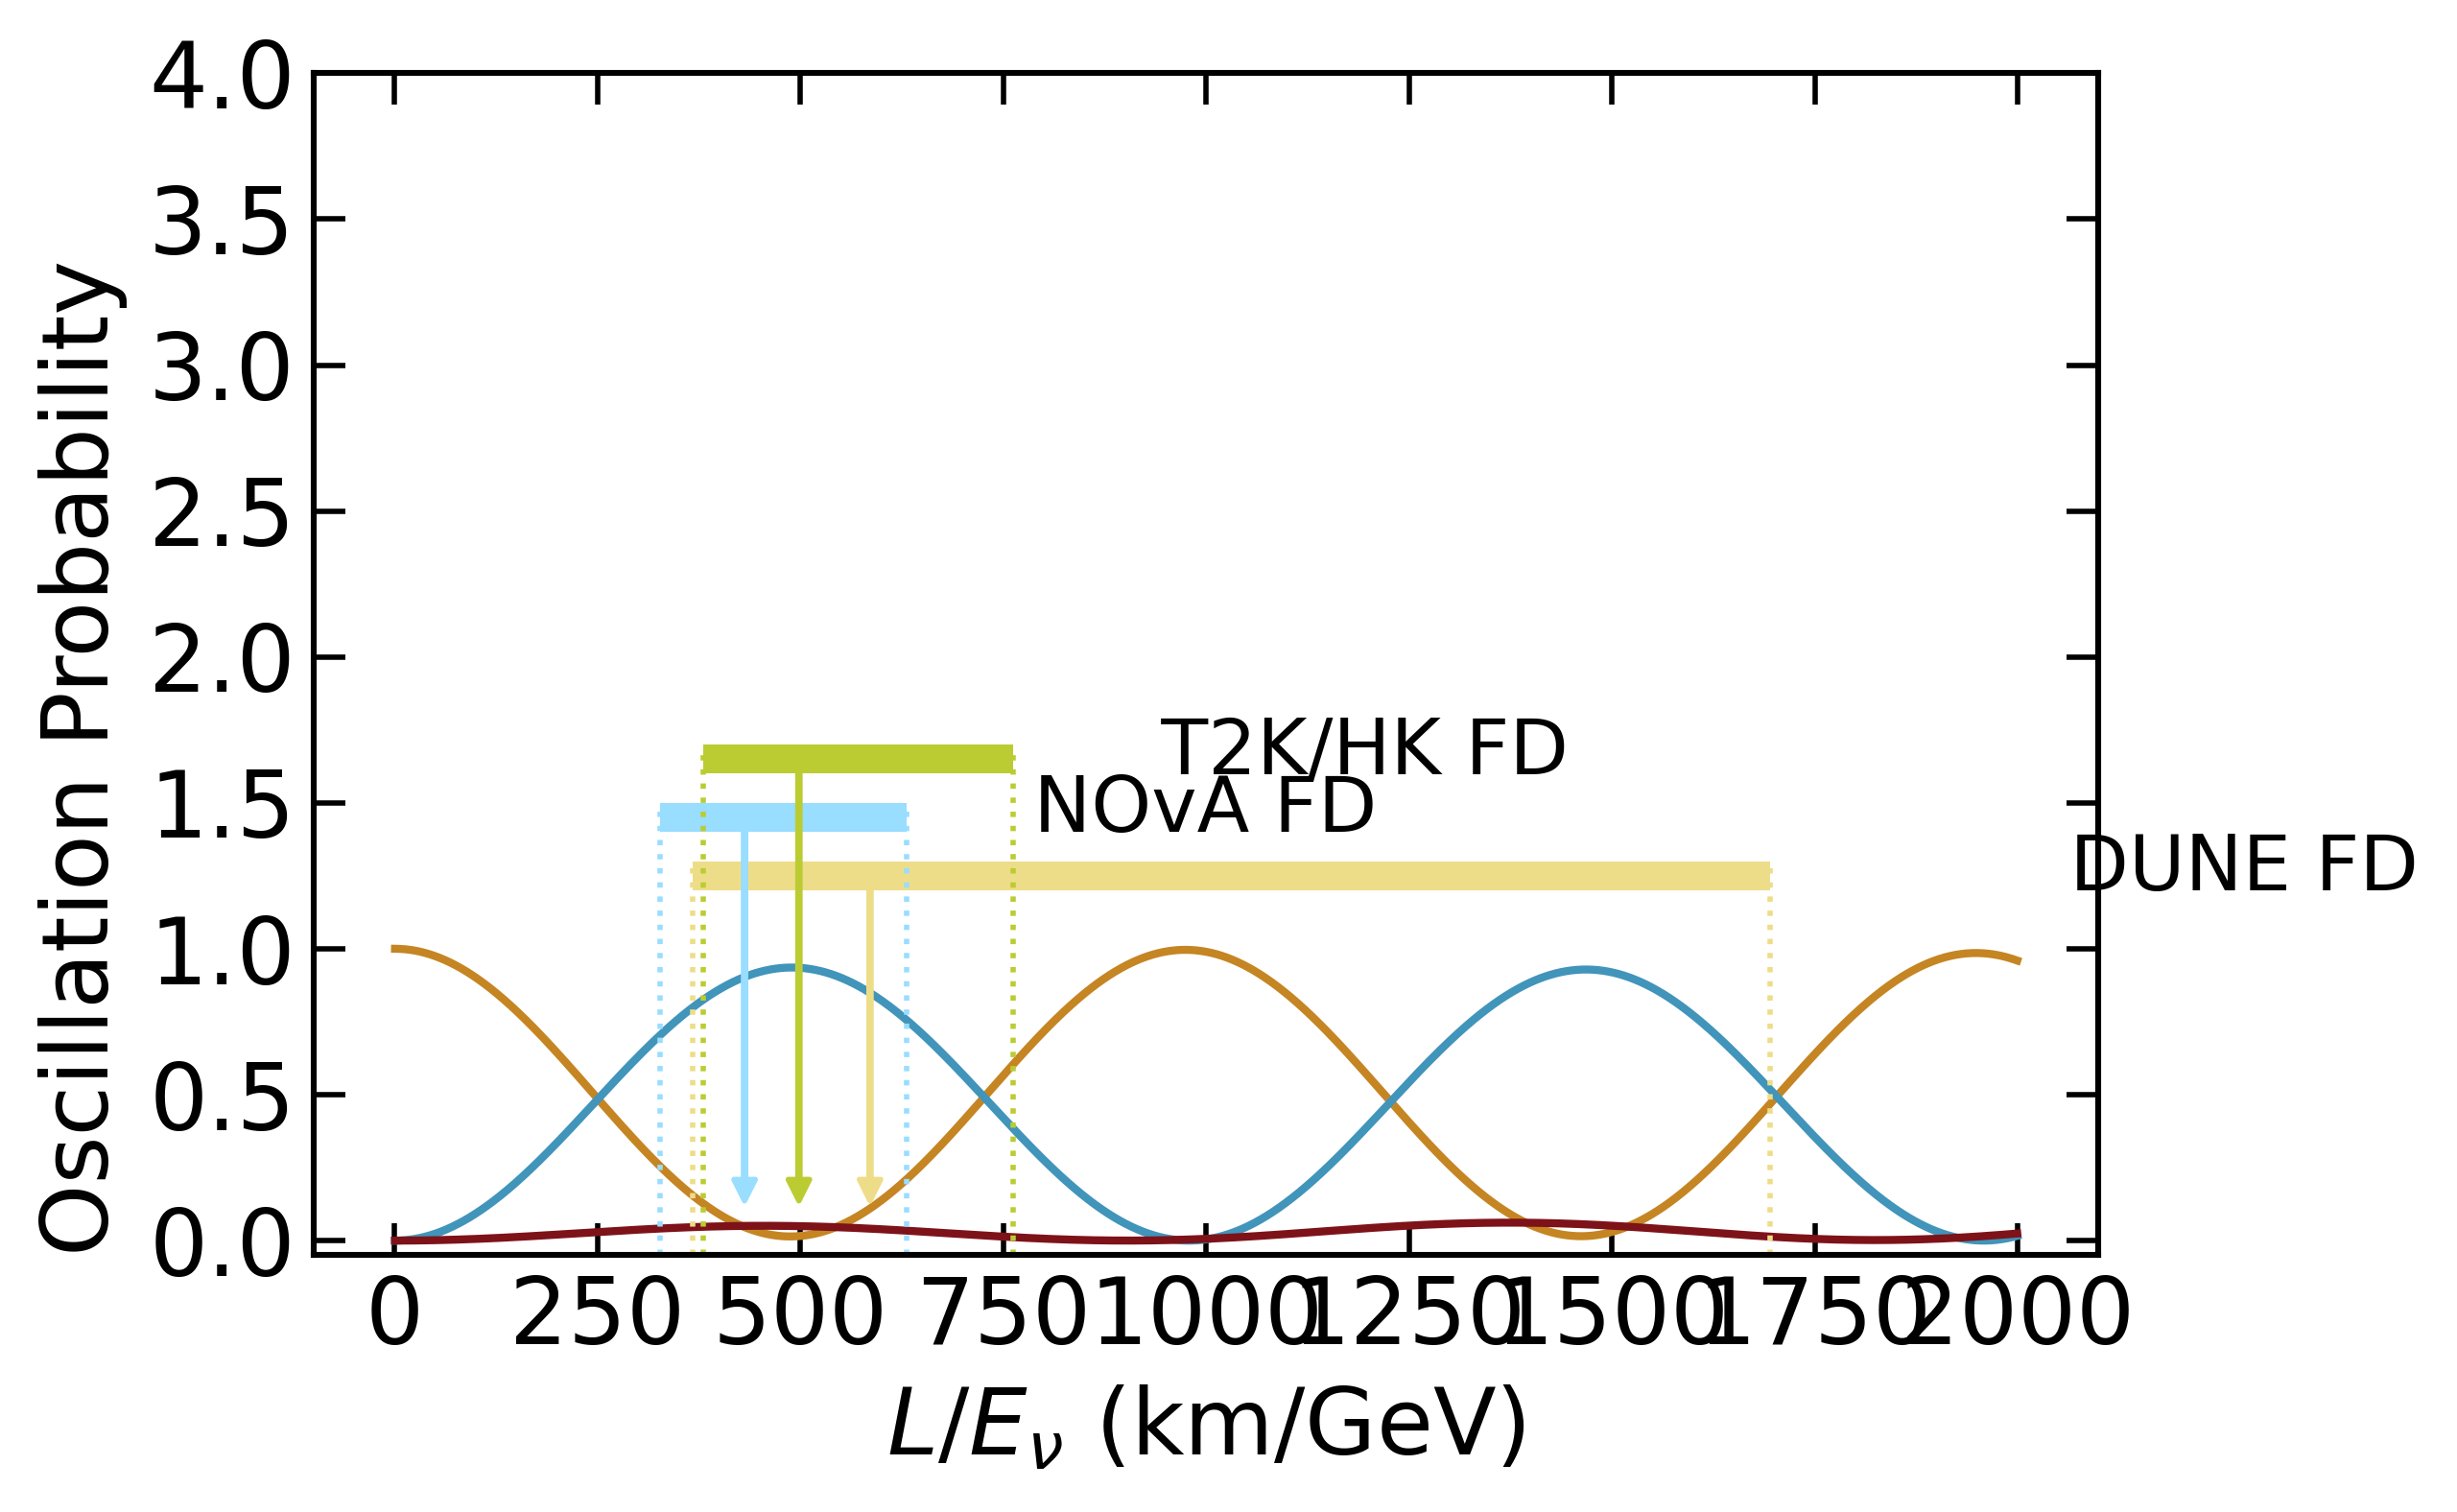

Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!


In [104]:
# print(MFWHMs)

import copy

MFWHMs["DUNE FD"] = MFWHMs["DUNE ND"]
MFWHMs["NOvA FD"] = MFWHMs["NOvA ND"]
MFWHMs["T2K/HK FD"] = MFWHMs["T2K/HK ND"]

Ls = {
    "DUNE FD": 1300.0,
    "NOvA FD": 810.0,
    "T2K/HK FD": 295.0,
}

shifts = {
    "DUNE FD": 400,
    "NOvA FD": -175,
    "T2K/HK FD": 0,
}

heights = {
    "DUNE FD": 1.2,
    "NOvA FD": 1.4,
    "T2K/HK FD": 1.6,
}

wnf5_disp2 = pn.Prob3plusplusWeightCalc()
wnf5_disp2.set_parameters({"baseline_km": 1, "NuFit:5.2": 1, "osc:numu_disp":1})

wnf5_app2 = pn.Prob3plusplusWeightCalc()
wnf5_app2.set_parameters({"baseline_km": 1, "NuFit:5.2": 1, "osc:numu_to_nue":1})

wnf5_tau2 = pn.Prob3plusplusWeightCalc()
wnf5_tau2.set_parameters({"baseline_km": 1, "NuFit:5.2": 1, "osc:from":14,"osc:to":16})

loe_points = pn.Binning.get_bin_centers1D(pn.Binning.log10_space(0.3, 2000, 10000).bins)

p_disp = [ wnf5_disp2.prob(1.0/x) for x in loe_points ]
p_app = [ wnf5_app2.prob(1.0/x) for x in loe_points ]
p_tau = [ wnf5_tau2.prob(1.0/x) for x in loe_points ]

prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']
print(def_colors)

# plt.xscale("log")
plt.ylim([-0.05,4])
plt.xlabel(r"$L/E_{\nu}$ (km/GeV)",fontsize="xx-large")
plt.ylabel(r"Oscillation Probability",fontsize="xx-large", loc="bottom")
plt.plot(loe_points,p_disp, label=r"$\nu_{\mu}\rightarrow\nu_{\mu}$, Survival",color="#c58523")
plt.plot(loe_points,p_tau, label=r"$\nu_{\mu}\rightarrow\nu_\text{e}$, Appearance",color="#4194ba")
plt.plot(loe_points,p_app, label=r"$\nu_{\mu}\rightarrow\nu_\text{e}$, Appearance",color="#7e1219")
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")

for i,(fn,l) in enumerate(Ls.items()):
    low = l/MFWHMs[fn][0][1]
    peak = l/MFWHMs[fn][1]
    high = l/MFWHMs[fn][0][0]
    col = MFWHMs[fn][2]
    # print("%s: [ %s, %s, %s ]" % (fn, low,peak,high))
    plt.gca().add_patch(Rectangle((low, heights[fn]), high - low, 0.1,
                                  clip_on=False, facecolor="%s"%col))

    plt.annotate('',xy=(peak,0.1), xycoords='data', 
                      xytext=(peak, heights[fn]+0.095), textcoords = 'data',
                   arrowprops={
                       "color":col,
                       "arrowstyle": 'simple,head_width=2,head_length=2',
                       "connectionstyle": 'arc3,rad=0'},
                   size=2)
    plt.plot([low,low], [-0.05,heights[fn]+0.095], 
             clip_on=False, linewidth=1, linestyle="dotted", color=col)
    plt.plot([high,high], [-0.05,heights[fn]+0.095], 
             clip_on=False, linewidth=1, linestyle="dotted", color=col)
    
    # plt.scatter(peak + shifts[fn],[1.5],clip_on=False,color=col)
    plt.text(high*1.2, heights[fn], " %s" % fn, fontsize="x-large")

plt.savefig("osc_e.svg",dpi=300)

## 